**Purpose:** Change network graph style.

In [1]:
import string
import numpy as np
import networkx as nx
import pubmed_parser as pp
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm.notebook import tqdm

In [2]:
pmids = [26016486, 25749135, 28828194, 27904610, 20974411]

In [3]:
def get_article(pmid):
    article = pp.parse_xml_web(pmid, sleep = 1)
    return article

In [4]:
articles = [get_article(pmid) for pmid in tqdm(pmids)]

In [5]:
def print_article(article):
    print(article['title'])
    print(article['authors'])
    print(article['journal'])
    print('https://www.ncbi.nlm.nih.gov/pubmed/' + article['pmid'])

In [6]:
def get_keys(article):
    key_list = []
    for key in article['keywords'].split(';'):
        if ':' in key:
            key = key.split(':')[1]
            key_list.append(key)
        else:
            key_list.append(key)
    keys = tokenize(' '.join(key_list))
    return keys

In [7]:
def tokenize(words):
    words = words.lower()
    words = words.translate(str.maketrans('', '', string.punctuation))
    tokens = np.array(words.split())
    return tokens

In [8]:
def common(arr1, arr2):
    score = len(np.intersect1d(arr1, arr2))
    return score

In [9]:
def similarity(article1, article2):
    
    keyword_arr1 = get_keys(article1)
    keyword_arr2 = get_keys(article2)
    keyword_ss = common(keyword_arr1, keyword_arr2) * 1000

    title_arr1 = tokenize(article1['title'])
    title_arr2 = tokenize(article2['title'])
    abstract_arr1 = tokenize(article1['abstract'])
    abstract_arr2 = tokenize(article2['abstract'])

    k1t2 = common(keyword_arr1, title_arr2)
    k2t1 = common(keyword_arr2, title_arr1)
    k1a2 = common(keyword_arr1, abstract_arr2)
    k2a1 = common(keyword_arr2, abstract_arr1)

    cross_arr = np.array([k1t2, k2t1, k1a2, k2a1])
    cross_weights = np.array([10, 10, 1, 1])
    cross_ss = np.dot(cross_arr, cross_weights)
    
    return keyword_ss, cross_ss

In [11]:
index = list(range(1, len(pmids) + 1))
keyword, cross = [], []

G = nx.Graph()
G.add_nodes_from(index)

for x, y in list(combinations(index, 2)):
    
    article1 = articles[x - 1]
    article2 = articles[y - 1]
    
    k, c = similarity(article1, article2)
    
    if k != 0:
        keyword.append([x, y])
        G.add_edge(x, y, weight = k)
        
    if (k == 0) and (c != 0):
        cross.append([x, y])
        G.add_edge(x, y, weight = c)

In [10]:
for i, article in enumerate(articles):
    print(i + 1)
    print_article(article)
    print('')

1
Staphylococcus aureus infections: epidemiology, pathophysiology, clinical manifestations, and management.
Steven Y C Tong; Joshua S Davis; Emily Eichenberger; Thomas L Holland; Vance G Fowler
Clinical microbiology reviews
https://www.ncbi.nlm.nih.gov/pubmed/26016486

2
Pathogenesis of Staphylococcus aureus abscesses.
Scott D Kobayashi; Natalia Malachowa; Frank R DeLeo
The American journal of pathology
https://www.ncbi.nlm.nih.gov/pubmed/25749135

3
Phage therapy: An alternative to antibiotics in the age of multi-drug resistance.
Derek M Lin; Britt Koskella; Henry C Lin
World journal of gastrointestinal pharmacology and therapeutics
https://www.ncbi.nlm.nih.gov/pubmed/28828194

4
Effects of air pollution on human health and practical measures for prevention in Iran.
Adel Ghorani-Azam; Bamdad Riahi-Zanjani; Mahdi Balali-Mood
Journal of research in medical sciences : the official journal of Isfahan University of Medical Sciences
https://www.ncbi.nlm.nih.gov/pubmed/27904610

5
Essentials

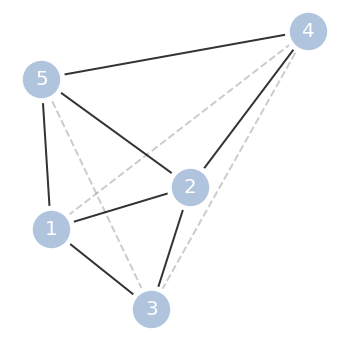

In [55]:
pos = nx.spring_layout(G)
plt.figure(figsize = (6, 6), facecolor = 'white')

nx.draw_networkx_nodes(G, pos, node_color = 'lightsteelblue', node_size = 1800, linewidths = 5, edgecolors = 'white')
nx.draw_networkx_edges(G, pos, edgelist = keyword, width = 2, alpha = 0.8)
nx.draw_networkx_edges(G, pos, edgelist = cross, width = 2, alpha = 0.2, style = 'dashed')
nx.draw_networkx_labels(G, pos, font_size = 20, font_family = 'sans-serif', font_color = 'white')

plt.axis('off')
plt.show()